<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_12/s12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download our code repository and install python dependencies

In [2]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!git clone "https://github.com/jyanivaddi/dl_hub.git"
!git pull
!pip install --quiet "torchinfo" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts"
!pip install --quiet "prettytable"
!pip install --quiet "torch_lr_finder"

Cloning into 'ERA_V1'...
remote: Enumerating objects: 964, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 964 (delta 59), reused 39 (delta 10), pack-reused 821
Receiving objects: 100% (964/964), 16.65 MiB | 30.01 MiB/s, done.
Resolving deltas: 100% (504/504), done.
fatal: not a git repository (or any of the parent directories): .git
Cloning into 'dl_hub'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 107 (delta 49), reused 79 (delta 27), pack-reused 0
Receiving objects: 100% (107/107), 20.29 KiB | 6.76 MiB/s, done.
Resolving deltas: 100% (49/49), done.
fatal: not a git repository (or any of the parent directories): .git
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

Add all the imports:

In [3]:
from __future__ import print_function
import os
import sys
from typing import Any
sys.path.append("dl_hub/models")
sys.path.append("ERA_V1/session_12")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from dl_hub.models.custom_resnet import CustomResnet, model_summary

Lightning related imports

In [4]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torchmetrics.functional import accuracy

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

Set up environment and add random seed

In [5]:
seed_everything(42)
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 512 if torch.cuda.is_available() else 64
NUM_WORKERS = 2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:lightning_fabric.utilities.seed:Global seed set to 42


Define data module

In [69]:
import numpy as np

class CifarDatasetWAlbumentations(Dataset):

    def __init__(self, dataset, transforms=None):
        self.transforms = transforms
        self.dataset = dataset


    def __len__(self) -> int:
        return len(self.dataset)


    def __getitem__(self, index) -> Any:
        image, label = self.dataset[index]
        image = np.array(image)
        if self.transforms is not None:
            image = self.transforms(image=image)["image"]
        return (image, label)

class CustomCifar10DataModule(LightningDataModule):
    def __init__(self, data_dir = PATH_DATASETS):
        # Initialize the class. Set up the datadir, image dims, and num classes
        super().__init__()
        self.data_dir = data_dir
        self.dims = (3, 32, 32)
        self.num_classes = 10
        self.train_transforms = A.Compose([
            A.transforms.PadIfNeeded(min_height=40, min_width=40),
            AA.crops.transforms.RandomCrop(height=32, width=32),
            A.HorizontalFlip(p=0.2),
            AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1,
                                                    max_height=8,
                                                    max_width=8,
                                                    min_holes = 1,
                                                    min_height=8,
                                                    min_width=8,
                                                    fill_value=(0.491, 0.482, 0.447),
                                                    mask_fill_value = None),
            A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
                        ToTensorV2()])
        self.val_transforms = A.Compose([
            A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
            ToTensorV2(),])

    def prepare_data(self):
        # Download the dataset
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == 'fit' or stage is None:
            self.train_dataset = CifarDatasetWAlbumentations(CIFAR10(self.data_dir, train=True),transforms = self.train_transforms)
            self.val_dataset = CifarDatasetWAlbumentations(CIFAR10(self.data_dir, train=False), transforms=self.val_transforms)
        if stage == 'test' or stage:
            self.test_dataset = CifarDatasetWAlbumentations(CIFAR10(self.data_dir, train=False), transforms=self.val_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS)

In [70]:
cifar10_dm = CustomCifar10DataModule(
    data_dir = PATH_DATASETS
)
cifar10_dm.prepare_data()
cifar10_dm.setup()


Files already downloaded and verified
Files already downloaded and verified


Let's build the Lightning ⚡ Module!

In [72]:
class LitResnet(LightningModule):
    def __init__(self, lr=0.03, drop_out_probability=0.1, num_classes=10,
                 base_channels=3):
        super().__init__()

        self.save_hyperparameters()
        self.model = CustomResnet(base_channels=base_channels,
                                  num_classes=num_classes,
                                  drop_out_probability=drop_out_probability)

    def forward(self, x):
        return self.model.forward(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        #loss = nn.CrossEntropyLoss(logits, y, reduction='mean')
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        #loss = nn.CrossEntropyLoss(logits, y, reduction='mean')
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y,"multiclass", num_classes=10)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_id):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(),
                               lr=self.hparams.lr,
                               weight_decay=1e-4)
        steps_per_epoch = 60000 // BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                4.65e-2,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
                pct_start = 5./self.trainer.max_epochs,
                div_factor=2000,
                three_phase=False,
                anneal_strategy='linear',
                verbose=False
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}


In [73]:
60000//BATCH_SIZE

117

Initiate and train the model

In [74]:
drop_out_probability=0.02
model = LitResnet(lr=0.01,base_channels=3, num_classes=10,
                  drop_out_probability=drop_out_probability)

trainer = Trainer(
    max_epochs=24,
    accelerator='auto',
    devices = 1 if torch.cuda.is_available() else None,
    logger = CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval='step'),
               TQDMProgressBar(refresh_rate=10)])

trainer.fit(model, cifar10_dm)
trainer.test(model, datamodule = cifar10_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | CustomResnet | 6.6 M 
---------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.292    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/content/dl_hub/models/custom_resnet.py:161: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=24` reached.


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8422999978065491     │
│         test_loss         │    0.47355717420578003    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.47355717420578003, 'test_acc': 0.8422999978065491}]

,lr-Adam,train_loss,val_loss,val_acc,test_loss,test_acc
epoch,,,,,,
NaN,0.003923,NaN,NaN,NaN,NaN,NaN
0.0,NaN,1.380146,NaN,NaN,NaN,NaN
0.0,NaN,NaN,1.204054,0.5881,NaN,NaN
NaN,0.007902,NaN,NaN,NaN,NaN,NaN
1.0,NaN,1.146888,NaN,NaN,NaN,NaN


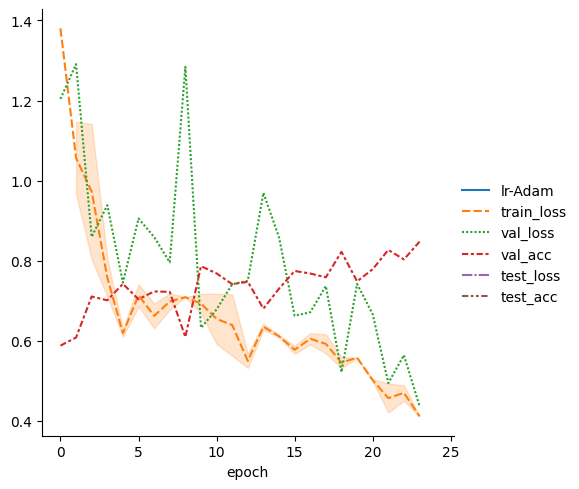

In [67]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")